In [139]:
import os
import dask.dataframe as dd
import soundfile as sf
import numpy as np
import pandas as pd
from dask import delayed
import librosa
import librosa.display
import noisereduce as nr
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
import seaborn as sns
import speech_recognition as sr
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2  # Import l2 for regularization
import matplotlib.pyplot as plt

In [140]:
final_audio_features_and_transcripts = pd.read_excel("Features_Audio_Mapping_Taz.xlsx")
# Assuming your data is in a DataFrame named `data`
audio_features = final_audio_features_and_transcripts[['MFCC_Avg', 'Chroma_Avg', 'Zero Crossing Rate', 'Duration', 'Spectral Centroid', 'Spectral Bandwidth']]

In [142]:
final_audio_features_and_transcripts.head(2)

,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,MFCC10,...,Chroma11,Chroma12,Zero Crossing Rate,Duration,Spectral Centroid,Spectral Bandwidth,File Path,Transcript,MFCC_Avg,Chroma_Avg
0,-538.036255,84.853241,-4.164584,15.917459,-2.224296,-8.303665,-17.790384,-21.168802,-19.567507,-8.814341,...,0.297345,0.303357,0.140659,14.340000,1719.035351,950.689701,D:\Rishi Documents and Data\Capstone Project -...,I want to thank you all for being here,-41.049420,0.286957
1,-569.061584,58.750671,-3.308123,12.576245,2.671778,-4.518902,-11.433702,-13.181439,-10.695546,-3.259475,...,0.342197,0.325971,0.126764,13.510023,1692.014702,882.435343,D:\Rishi Documents and Data\Capstone Project -...,is there anyone outside of the campaign that's...,-42.342303,0.320733


In [155]:
audio_features.head(2)

,MFCC_Avg,Chroma_Avg,Zero Crossing Rate,Duration,Spectral Centroid,Spectral Bandwidth
0,-41.049420,0.286957,0.140659,14.340000,1719.035351,950.689701
1,-42.342303,0.320733,0.126764,13.510023,1692.014702,882.435343


In [269]:
scaler = StandardScaler()
normalized_audio_features = scaler.fit_transform(audio_features)

normalized_audio_features_df = pd.DataFrame(normalized_audio_features, columns=audio_features.columns)
normalized_audio_features_df=np.array(normalized_audio_features_df)
normalized_audio_features_df

array([[ 0.11644693, -1.2856272 ,  0.37086764,  0.07023199, -0.22982772,
        -0.50129827],
       [-0.08951712, -0.25225472, -0.16379642, -0.33814118, -0.32605917,
        -1.08776648],
       [-0.08317708, -1.61093818,  0.60181145,  0.11943492,  0.3089114 ,
        -2.14625244],
       ...,
       [ 0.09121092,  0.69442337,  0.11664177,  0.17847844, -0.20733909,
        -0.74943624],
       [ 1.07115109,  0.64957955, -0.1537001 ,  0.37038103, -0.18488815,
        -0.73471702],
       [ 1.35183777,  0.18060877,  0.82658206,  0.13420696,  0.90400616,
         0.10538009]])

In [202]:
transcripts = final_audio_features_and_transcripts['Transcript']
transcripts=np.array(transcripts)
transcripts.shape

(21253,)

In [175]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming `transcripts` is your array of text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(transcripts)
sequences = tokenizer.texts_to_sequences(transcripts)

# Set vocab size
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token

In [176]:
import numpy as np

# Load GloVe embeddings
embedding_dim = 100  # Choose the embedding dimension (e.g., 50, 100, 200, 300)
embeddings_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:  # Adjust the path and dimension
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [177]:
# Pad sequences
max_length = max(len(s) for s in sequences)  # Find the max length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
padded_sequences

array([[   8,   60,    2, ...,    0,    0,    0],
       [  10,   40,  346, ...,    0,    0,    0],
       [1160,   17,   50, ...,    0,    0,    0],
       ...,
       [ 302,  413,  238, ...,    0,    0,    0],
       [  87,  238,   34, ...,    0,    0,    0],
       [1148,    9,   38, ...,    0,    0,    0]])

In [178]:
# First split: Train + Validation and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(normalized_audio_features_df, padded_sequences, test_size=0.2, random_state=42)

# Second split: Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2 of total

In [186]:
print(X_train.shape)  # Verify shape
print(X_val.shape)
print(X_test.shape)

(12751, 6)
(4251, 6)
(4251, 6)


In [208]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Concatenate, TimeDistributed

# Define input dimensions
audio_features_dim = X_train.shape[1]  # Should be 6 based on your data
max_length = padded_sequences.shape[1]  # Length of padded sequences

# Input layers
audio_input = Input(shape=(audio_features_dim,), name='audio_input')
text_input = Input(shape=(max_length,), name='text_input')

# Embedding layer using GloVe embeddings
embedding_layer = Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            weights=[embedding_matrix], 
                            input_length=max_length, 
                            trainable=False)(text_input)



# GRU layer
gru_layer = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)

# Concatenate audio features with each time step of the GRU output
audio_features_repeated = tf.keras.layers.RepeatVector(max_length)(audio_input)
combined = Concatenate()([gru_layer, audio_features_repeated])

# Dense layer for the final output, TimeDistributed to apply it to each time step
output = TimeDistributed(Dense(vocab_size, activation='softmax'))(combined)

# Create the model
model = Model(inputs=[audio_input, text_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' for multi-class
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 77)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_10 (Embedding)      │ (None, 77, 100)           │       1,973,500 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ audio_input (InputLayer)      │ (None, 6)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_12              │ (None, 77, 128)           │          63,744 │ embedding_10[0][0]         │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ repeat_vector_1               │ (None, 77, 6)             │               0 │ audio_input[0][0]          │
│ (RepeatVector)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 77, 134)           │               0 │ bidirectional_12[0][0],    │
│                               │                           │                 │ repeat_vector_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time_distributed              │ (None, 77, 19735)         │       2,664,225 │ concatenate_3[0][0]        │
│ (TimeDistributed)             │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,701,469 (17.93 MB)

 Trainable params: 2,727,969 (10.41 MB)

 Non-trainable params: 1,973,500 (7.53 MB)

In [211]:
# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit([X_train, y_train], 
                    y_train, 
                    epochs=1, 
                    batch_size=128, 
                    validation_data=([X_val, y_val], y_val),
                    callbacks=[early_stopping])

100/100 ━━━━━━━━━━━━━━━━━━━━ 877s 9s/step - accuracy: 0.5996 - loss: 2.9145 - val_accuracy: 0.6477 - val_loss: 2.4376


In [212]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test, y_test], y_test)

# Extract the final training and validation accuracy and loss
final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the results
print(f'Final Train Loss: {final_train_loss:.4f}')
print(f'Final Train Accuracy: {final_train_accuracy:.4f}')
print(f'Final Validation Loss: {final_val_loss:.4f}')
print(f'Final Validation Accuracy: {final_val_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

133/133 ━━━━━━━━━━━━━━━━━━━━ 95s 705ms/step - accuracy: 0.6491 - loss: 2.4287
Final Train Loss: 2.7318
Final Train Accuracy: 0.6150
Final Validation Loss: 2.4376
Final Validation Accuracy: 0.6477
Test Loss: 2.4082
Test Accuracy: 0.6523


In [328]:
audio_path = 'audio.flac'  # Replace with the path to your audio file
y, sr = librosa.load(audio_path, sr=None)

# Reduce noise
y_denoised = nr.reduce_noise(y=y, sr=sr)

In [329]:
# Extract features

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y_denoised, sr=sr, n_mfcc=13)
mfccs_avg = np.mean(mfccs)

# Extract chroma features
chroma = librosa.feature.chroma_stft(y=y_denoised, sr=sr)
chroma_avg = np.mean(chroma)

# Extract Zero-Crossing Rate
zcr = librosa.feature.zero_crossing_rate(y_denoised)
zcr_avg = np.mean(zcr)

# Extract Spectral Centroid
spectral_centroid = librosa.feature.spectral_centroid(y=y_denoised, sr=sr)
spectral_centroid_avg=np.mean(spectral_centroid)

# Extract Spectral Bandwidth
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_denoised, sr=sr)
spectral_bandwidth_avg=np.mean(spectral_bandwidth)

# Extract Duration
duration = librosa.get_duration(y=y_denoised, sr=sr)

# Combine only the specified features into a single array
new_audio_features = np.array([
    mfccs_avg,      # MFCC_Avg
    chroma_avg,    # Chroma_Avg
    zcr_avg,  # Zero Crossing Rate
    duration,            # Duration
    spectral_centroid_avg,  # Spectral Centroid
    spectral_bandwidth_avg   # Spectral Bandwidth
])

In [330]:
new_audio_features

array([-4.21132584e+01,  2.75877982e-01,  1.45126179e-01,  1.49200000e+01,
        1.44668969e+03,  7.97490545e+02])

In [331]:
# Ensure the array is 2D for the scaler
new_audio_features = new_audio_features.reshape(1, -1)
new_audio_features

array([[-4.21132584e+01,  2.75877982e-01,  1.45126179e-01,
         1.49200000e+01,  1.44668969e+03,  7.97490545e+02]])

In [332]:
scaler = StandardScaler()
scaler.fit(audio_features)  # This should be the audio_features from your training data

# Normalize the new audio features
normalized_new_audio_features = scaler.transform(new_audio_features)

print(normalized_new_audio_features)

[[-0.0530289  -1.62457252  0.54275505  0.35560899 -1.19976065 -1.8176455 ]]


C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [336]:
def sample(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)
    
def generate_transcript(model, audio_features, tokenizer, max_length, temperature=1.0):
    # Prepare the input for the model
    audio_input = np.expand_dims(audio_features, axis=0)

    normalized_audio_input = scaler.transform(audio_input)
    
    # Start with the start token
    start_sequence = [tokenizer.word_index.get('<start>', 1)]  # Use 1 or your start token index
    
    for _ in range(max_length):
        # Pad the current sequence
        text_input = pad_sequences([start_sequence], maxlen=max_length, padding='post')
        
        # Predict the next word
        prediction = model.predict([normalized_audio_input, text_input])
        
        # Get the predicted word index using temperature sampling
        predicted_word_index = sample(prediction[0, len(start_sequence)-1, :], temperature=temperature)
        
        # Append the predicted word to the sequence
        start_sequence.append(predicted_word_index)
        
        # Check for the end token
        # Uncomment the following lines if you have an end token
        # if predicted_word_index == tokenizer.word_index.get('<end>', -1):  
        #     break
            
    # Convert the sequence of indices to words
    inverse_word_index = {index: word for word, index in tokenizer.word_index.items()}
    generated_transcript = ' '.join([inverse_word_index.get(index, '') for index in start_sequence if index > 0])
    
    return generated_transcript

# Example usage
max_length = 77  # Adjust this to your maximum sequence length
generated_transcript = generate_transcript(model, normalized_new_audio_features[0], tokenizer, max_length, temperature=0.7)
print(f'Generated Transcript: {generated_transcript}')

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

# **DO NOT USE THE BELOW CODE**

In [10]:
# Convert data to lists of strings if they are not already
X_train_texts = [str(text) for text in X_train]
X_val_texts = [str(text) for text in X_val]
X_test_texts = [str(text) for text in X_test]

y_train_texts = [str(text) for text in y_train]
y_val_texts = [str(text) for text in y_val]
y_test_texts = [str(text) for text in y_test]

In [136]:
X_train.head

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [11]:
# Assuming tokenizer is already created and fitted
def create_sequences(texts, tokenizer, maxlen=None):
    if not isinstance(texts, list):
        raise TypeError("Expected a list of texts.")
    sequences = tokenizer.texts_to_sequences(texts)
    if maxlen:
        sequences = pad_sequences(sequences, maxlen=maxlen, padding='post')
    else:
        sequences = pad_sequences(sequences, padding='post')
    return np.array(sequences)  # Convert to NumPy array

In [12]:
# Prepare the data
X_train_sequences = create_sequences(X_train_texts, tokenizer, maxlen=100)  # Set maxlen to the desired sequence length
X_val_sequences = create_sequences(X_val_texts, tokenizer, maxlen=100)
X_test_sequences = create_sequences(X_test_texts, tokenizer, maxlen=100)

decoder_input_data_train = create_sequences(y_train_texts, tokenizer, maxlen=100)
decoder_input_data_val = create_sequences(y_val_texts, tokenizer, maxlen=100)
decoder_input_data_test = create_sequences(y_test_texts, tokenizer, maxlen=100)

In [13]:
# Parameters
input_dim = X_train_sequences.shape[1]  # Number of features after padding
output_dim = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 100  # Should match GloVe dimensions
units = 256

# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [14]:
# Define the encoder with Bidirectional GRU
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=output_dim, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(encoder_inputs)
encoder = Bidirectional(GRU(units, return_state=True, kernel_regularizer=l2(0.001)))
encoder_outputs, forward_state, backward_state = encoder(encoder_embedding)

# Concatenate the forward and backward states
encoder_state = Concatenate()([forward_state, backward_state])

# Define the decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=output_dim, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(decoder_inputs)
decoder_gru = GRU(units * 2, return_sequences=True, return_state=True, kernel_regularizer=l2(0.001))  # units * 2 because of concatenation
decoder_outputs, _ = decoder_gru(decoder_embedding, initial_state=encoder_state)
decoder_dropout = Dropout(0.5)(decoder_outputs)
decoder_dense = Dense(output_dim, activation='softmax', kernel_regularizer=l2(0.001))
decoder_outputs = decoder_dense(decoder_dropout)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model with a specified learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0006),  # Adjust the learning rate as needed
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, None, 100)         │       1,973,500 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ [(None, 512), (None,      │         549,888 │ embedding[0][0]            │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, None, 100)         │       1,973,500 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 512)               │               0 │ bidirectional[0][1],       │
│                               │                           │                 │ bidirectional[0][2]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_1 (GRU)                   │ [(None, None, 512),       │         943,104 │ embedding_1[0][0],         │
│                               │ (None, 512)]              │                 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, None, 512)         │               0 │ gru_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, None, 19735)       │      10,124,055 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 15,564,047 (59.37 MB)

 Trainable params: 11,617,047 (44.32 MB)

 Non-trainable params: 3,947,000 (15.06 MB)

In [15]:
# Verify the shapes of your datasets
print(f"X_train_sequences shape: {X_train_sequences.shape}")
print(f"y_train_sequences shape: {decoder_input_data_train.shape}")
print(f"X_val_sequences shape: {X_val_sequences.shape}")
print(f"y_val_sequences shape: {decoder_input_data_val.shape}")
print(f"X_test_sequences shape: {X_test_sequences.shape}")
print(f"y_test_sequences shape: {decoder_input_data_test.shape}")


X_train_sequences shape: (17002, 100)
y_train_sequences shape: (17002, 100)
X_val_sequences shape: (2126, 100)
y_val_sequences shape: (2126, 100)
X_test_sequences shape: (2125, 100)
y_test_sequences shape: (2125, 100)


In [16]:
# Prepare target sequences for training, validation, and test
decoder_target_data_train = create_sequences(y_train_texts, tokenizer, maxlen=100)
decoder_target_data_val = create_sequences(y_val_texts, tokenizer, maxlen=100)
decoder_target_data_test = create_sequences(y_test_texts, tokenizer, maxlen=100)

In [17]:
# Train the model
history = model.fit(
    [X_train_sequences, decoder_input_data_train],
    decoder_target_data_train,  # y_train data
    epochs=3,
    batch_size=16,
    validation_data=([X_val_sequences, decoder_input_data_val], decoder_target_data_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


Epoch 1/3
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2098s 2s/step - accuracy: 0.7391 - loss: 1.9845 - val_accuracy: 0.8740 - val_loss: 0.8184
Epoch 2/3
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2114s 2s/step - accuracy: 0.8715 - loss: 0.8165 - val_accuracy: 0.9065 - val_loss: 0.7355
Epoch 3/3
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 2159s 2s/step - accuracy: 0.8950 - loss: 0.7585 - val_accuracy: 0.9185 - val_loss: 0.7086


In [18]:
# Evaluate on training data
train_loss, train_accuracy = model.evaluate([X_train_sequences, decoder_input_data_train],  # Inputs for encoder and decoder
                                            decoder_target_data_train  # True target data
                                            )
print(f"Train loss: {train_loss}")

print(f"Train accuracy: {train_accuracy}")

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate([X_val_sequences, decoder_input_data_val],  # Inputs for encoder and decoder
                                        decoder_target_data_val  # True target data
                                        )
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")

 # Evaluate on test data
test_loss, test_accuracy = model.evaluate([X_test_sequences, decoder_input_data_test],  # Inputs for encoder and decoder
                                          decoder_target_data_test  # True target data
                                          )
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")



532/532 ━━━━━━━━━━━━━━━━━━━━ 464s 872ms/step - accuracy: 0.9201 - loss: 0.7001
Train loss: 0.7011469602584839
Train accuracy: 0.9197682738304138
67/67 ━━━━━━━━━━━━━━━━━━━━ 60s 894ms/step - accuracy: 0.9176 - loss: 0.7128
Validation loss: 0.7085828185081482
Validation accuracy: 0.9185373187065125
67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 881ms/step - accuracy: 0.9197 - loss: 0.7020
Test loss: 0.6979268789291382
Test accuracy: 0.9204329252243042


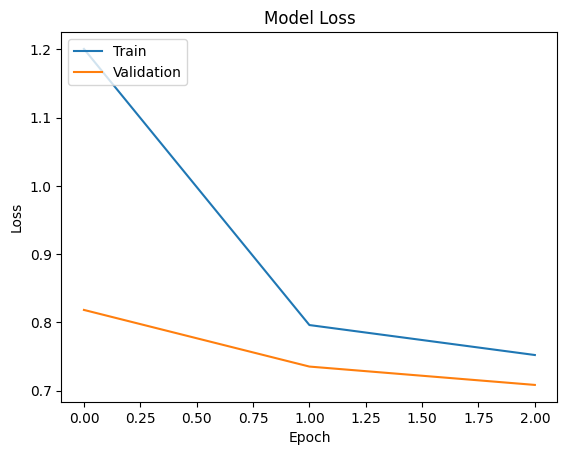

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [20]:
# Save the model
model.save('CER_Model.h5')

In [51]:
# Load the trained model
model = load_model('CER_Model.h5')

In [52]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, None, 100)         │       1,973,500 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ [(None, 512), (None,      │         549,888 │ embedding[0][0]            │
│                               │ 256), (None, 256)]        │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, None, 100)         │       1,973,500 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 512)               │               0 │ bidirectional[0][1],       │
│                               │                           │                 │ bidirectional[0][2]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_1 (GRU)                   │ [(None, None, 512),       │         943,104 │ embedding_1[0][0],         │
│                               │ (None, 512)]              │                 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, None, 512)         │               0 │ gru_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, None, 19735)       │      10,124,055 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 15,564,049 (59.37 MB)

 Trainable params: 11,617,047 (44.32 MB)

 Non-trainable params: 3,947,000 (15.06 MB)

 Optimizer params: 2 (12.00 B)

**Test audio file**

In [103]:
# Function to reduce noise in audio
def reduce_noise(y, sr):
    return nr.reduce_noise(y=y, sr=sr)

In [94]:
def preprocess_audio_file(file_path):
    y, sr = librosa.load(file_path)
    
    # Reduce noise
    y = reduce_noise(y, sr)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Extract chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)

    # Extract Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)

    # Extract Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

    # Extract Spectral Bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    # Extract Duration
    duration = librosa.get_duration(y=y, sr=sr)

    # Create a DataFrame with extracted features
    features = pd.DataFrame({
        'MFCC_Avg': np.mean(mfccs_mean),  # Average of MFCCs
        'Chroma_Avg': np.mean(chroma_mean),  # Average of Chroma features
        'Zero Crossing Rate': zcr_mean,
        'Duration': duration,
        'Spectral Centroid': spectral_centroid,
        'Spectral Bandwidth': spectral_bandwidth
    },index=[0])

    return features

In [95]:
def prepare_input(features, scaler, tokenizer):
    # Normalize the features
    normalized_features = scaler.transform(features)

    # Create sequences for the decoder
    input_sequences = create_sequences([''], tokenizer, maxlen=100)  # Empty input for decoder
    return normalized_features, input_sequences

In [96]:
def predict_transcript(file_path, scaler, tokenizer):
    # Preprocess the audio file
    features = preprocess_audio_file(file_path)

    # Prepare input for the model
    X_input, decoder_input = prepare_input(features, scaler, tokenizer)

    # Make predictions
    predictions = model.predict([X_input, decoder_input])

    # Get the index of the highest probability
    predicted_sequence = np.argmax(predictions, axis=-1)
    return predicted_sequence

In [97]:
def decode_sequence(sequence, tokenizer):
    # Convert back to words
    decoded_text = tokenizer.sequences_to_texts(sequence)
    return decoded_text[0]

In [59]:
def test_model_on_audio_file(file_path):
    # Step 1: Load and preprocess the audio file
    y, sr = librosa.load(file_path)
    y = nr.reduce_noise(y=y, sr=sr)  # Reduce noise

    # Step 2: Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    zcr_mean = np.mean(librosa.feature.zero_crossing_rate(y))
    duration = librosa.get_duration(y=y, sr=sr)
    centroid_mean = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth_mean = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    # Step 3: Create a DataFrame for the extracted features dynamically
    audio_features = pd.DataFrame()

    # Add MFCC features (using a single 'MFCC_Avg' feature as an example)
    audio_features['MFCC_Avg'] = [np.mean(mfccs_mean)]

    # Add Chroma features (using a single 'Chroma_Avg' feature as an example)
    audio_features['Chroma_Avg'] = [np.mean(chroma_mean)]

    # Add other features (keep these as they are)
    audio_features['Zero Crossing Rate'] = [zcr_mean]
    audio_features['Duration'] = [duration]
    audio_features['Spectral Centroid'] = [centroid_mean]
    audio_features['Spectral Bandwidth'] = [bandwidth_mean]

    # Step 4: Normalize the features
    normalized_features = scaler.transform(audio_features)

    # Step 5: Convert features to sequence
    input_sequence = create_sequences([str(normalized_features)], tokenizer, maxlen=100)

    # Debugging: Check for invalid indices in input_sequence
    if np.any(input_sequence < 0) or np.any(input_sequence >= len(tokenizer.word_index) + 1):
        print("Warning: Found invalid indices in input_sequence")
    else:
        print("input_sequence contains valid indices")

    decoder_input_sequence = np.zeros((1, max_sequence_length), dtype=int)

    # Debugging: Check input types and shapes
    # print(f"input_sequence type: {type(input_sequence)}, shape: {input_sequence.shape}")
    # print(f"decoder_input_sequence type: {type(decoder_input_sequence)}, shape: {decoder_input_sequence.shape}")

    # Debugging: Print initial input values
    # print(f"Initial input_sequence: {input_sequence}")
    # print(f"Initial decoder_input_sequence: {decoder_input_sequence}")

    # Debugging: Print model summary
    # model.summary()

    # Step 6: Perform a single prediction for debugging
    try:
        predicted_sequence = model.predict([input_sequence, decoder_input_sequence])
        print("Single prediction successful")
    except Exception as e:
        print(f"Error during single prediction: {e}")
        return

    # Step 7: Predict using the model iteratively
    predicted_indices = []
    for i in range(max_sequence_length):
        try:
            predicted_sequence = model.predict([input_sequence, decoder_input_sequence])
        except Exception as e:
            print(f"Error during iterative prediction at step {i+1}: {e}")
            return

        # Debugging: Print shape of the predicted sequence
        # print(f"Shape of predicted_sequence: {predicted_sequence.shape}")

        # If the predicted_sequence has shape (1, max_sequence_length, vocab_size)
        if len(predicted_sequence.shape) == 3:
            next_token = np.argmax(predicted_sequence[0, i, :])
        else:
            next_token = np.argmax(predicted_sequence[0, :])

        # Debugging: Print the next token and validate it
        # print(f"Step {i+1}, Predicted token index: {next_token}")

        # Clamp next_token to be within the valid range
        if next_token >= len(tokenizer.word_index) or next_token < 0:
            print(f"Invalid token index {next_token} found, clamping to 0.")
            next_token = 0  # Assuming 0 is the index for padding or unknown tokens

        predicted_indices.append(next_token)
        if i+1 < max_sequence_length:
            decoder_input_sequence[0, i+1] = next_token  # Update decoder input for the next time step

    # Step 8: Convert the predicted sequence back to text
    predicted_text = tokenizer.sequences_to_texts([predicted_indices])

    return predicted_text



In [60]:
# Example usage with a random audio file
audio_file = 'audio 1.flac'
predicted_transcript = test_model_on_audio_file(audio_file)
print("Predicted Transcript:", predicted_transcript)


input_sequence contains valid indices
1/1 [==============================] - 0s 117ms/step
Single prediction successful
1/1 [==============================] - 0s 105ms/step
Predicted Transcript: ['136 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 132']
